# Uncertainty Quantification on M5 competition sales data



## Loading packages 

In [ ]:
!pip install nnetsauce xgboost lightgbm numpy pandas scikit-learn

In [2]:
import nnetsauce as ns
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

## Useful functions

In [3]:
def calculate_coverage(lower_pred, upper_pred, y_true):
    """Calculate coverage of the prediction intervals."""
    within_bounds = np.logical_and(lower_pred <= y_true, y_true <= upper_pred)
    return np.mean(within_bounds)

def calculate_winkler_score(lower_pred, upper_pred, y_true, alpha=0.05):
    """Calculate Winkler score for predictions."""

    penalty = 2*np.maximum(lower_pred - y_true, 0)/alpha

    penalty += 2*np.maximum(y_true - upper_pred, 0)/alpha

    scores = (upper_pred - lower_pred) + penalty

    return np.mean(scores)


## Loading data <a class="anchor" id="data"></a>

### Sales Training Data

In [4]:
df = pd.read_csv("m5-forecasting-uncertainty-sales-per-item.csv")
df.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_001,6,6,4,6,7,18,10,4,11,...,4,4,30,7,5,3,6,2,16,6
1,FOODS_1_002,4,5,7,4,3,4,1,7,2,...,5,9,4,1,3,5,5,3,3,1
2,FOODS_1_003,14,8,3,6,3,8,13,10,11,...,7,3,5,6,3,4,4,3,11,5
3,FOODS_1_004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FOODS_1_005,34,32,13,20,10,21,18,20,25,...,16,14,14,18,18,27,12,15,38,9


In [6]:
print(df.describe())

          d_1     d_2     d_3     d_4     d_5     d_6     d_7     d_8     d_9  \
count 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00   
mean    10.70   10.41    7.80    8.33    6.28    9.58    9.19   12.44   10.74   
std     40.83   42.11   27.32   33.27   23.33   35.77   37.81   51.89   44.53   
min      0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
25%      0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
50%      0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
75%      9.00    9.00    6.00    7.00    5.00    8.00    7.00   10.00    9.00   
max   1345.00 1534.00  757.00 1196.00  749.00 1064.00 1187.00 1745.00 1367.00   

         d_10  ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  d_1910  \
count 3049.00  ... 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00 3049.00   
mean     8.39  ...   13.71   15.86   16.94   12.48   12.32   11.59   11.49   
std     28.00  ...   27.06   31.44  

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Columns: 1914 entries, item_id to d_1913
dtypes: int64(1913), object(1)
memory usage: 44.5+ MB
None


# Forecasting

In [8]:
from time import time

## Functions

In [12]:
def forecast(df, idx=0, model="xgb", pi_method= "quantile",
             pct_train=0.9, **kwargs):

  assert pct_train > 0.6, "must have pct_train > 0.6"

  x = df.iloc[idx, 1:].diff().dropna().values.astype(np.float64)
  n_points = len(x)
  x_train = x[:int(n_points*pct_train)].ravel()
  x_test = x[int(n_points*pct_train):].ravel()
  lags = 1 # number of lags to consider
  h = len(x_test)

  if pi_method == "conformal":

    if model == "xgb":
      regr = ns.MTS(obj=xgb.XGBRegressor(
                  tree_method="hist", **kwargs),
                  n_hidden_features=0,
                  type_pi="scp2-kde",
                  replications=250,
                  lags=lags,
                  show_progress=False,
                  verbose=0)
    elif model == "gb":
      regr = ns.MTS(obj=GradientBoostingRegressor(**kwargs),
                      n_hidden_features=0,
                      type_pi="scp2-kde",
                      replications=250,
                      lags=lags,
                      show_progress=False,
                      verbose=0)
    elif model == "lgb":
      regr = ns.MTS(obj=lgb.LGBMRegressor(verbosity=-1, **kwargs),
                      n_hidden_features=0,
                      type_pi="scp2-kde",
                      replications=250,
                      lags=lags,
                      show_progress=False,
                      verbose=0)
    else:
      raise NotImplementedError

    start = time()
    res = regr.fit(x_train).predict(h = h)
    time_taken = time() - start

    lower_pred = res.lower.values.ravel()
    upper_pred = res.upper.values.ravel()
    y_true = x_test

  elif pi_method == "quantile":

    if model == "xgb":
      bounds =[]
      for i, alpha in enumerate([0.025, 0.975]):
        regr = ns.MTS(obj=xgb.XGBRegressor(objective="reg:quantileerror",
                          tree_method="hist",
                          quantile_alpha=alpha, **kwargs),
                          n_hidden_features=0,
                          lags=lags,
                          show_progress=False,
                          verbose=0)
        start = time()
        regr.fit(x_train)
        time_taken = time() - start
        bounds.append(regr.predict(h = h))
    elif model == "gb":
      bounds =[]
      for i, alpha in enumerate([0.025, 0.975]):
        regr = ns.MTS(obj=GradientBoostingRegressor(loss="quantile",
                                            alpha=alpha, **kwargs),
                          n_hidden_features=0,
                          lags=lags,
                          show_progress=False,
                          verbose=0)
        start = time()
        regr.fit(x_train)
        bounds.append(regr.predict(h = h))
        time_taken = time() - start
    elif model == "lgb":
      bounds =[]
      for i, alpha in enumerate([0.025, 0.975]):
        regr = ns.MTS(obj=lgb.LGBMRegressor(objective = 'quantile',
                                alpha = alpha,
                                verbosity=-1, **kwargs),
                          n_hidden_features=0,
                          lags=lags,
                          show_progress=False,
                          verbose=0)
        start = time()
        regr.fit(x_train)
        bounds.append(regr.predict(h = h))
        time_taken = time() - start
    else:
      raise NotImplementedError

    lower_pred = bounds[0].values.ravel()
    upper_pred = bounds[1].values.ravel()
    y_true = x_test

  return calculate_coverage(lower_pred, upper_pred, y_true), calculate_winkler_score(lower_pred, upper_pred, y_true), time_taken


## loop

In [14]:
res = []

In [15]:
from tqdm import tqdm

Parallel

In [16]:
from joblib import Parallel, delayed
from tqdm import tqdm

# Define a function to handle the forecasting for each store_idx
def process_forecast(store_idx):
    result = []
    for model in ["xgb", "gb", "lgb"]:
        for pi_method in ["quantile", "conformal"]:
            try:
                ans = forecast(df, idx=store_idx, model=model, pi_method=pi_method)
                result.append([model, pi_method, ans[0], ans[1], ans[2]])
            except Exception as e:
                continue
    return result

# Parallelize using joblib's Parallel and delayed
# n_jobs=-1 uses all available cores; you can adjust this value as needed
res = Parallel(n_jobs=-1)(delayed(process_forecast)(store_idx) for store_idx in tqdm(range(df.shape[0])))

# Flatten the results list since each iteration returns a list
res = [item for sublist in res for item in sublist]


100%|██████████| 3049/3049 [7:39:00<00:00,  9.03s/it]  


In [17]:
res_array = np.array(res)

In [18]:
res_df = pd.DataFrame(res_array, columns=["model", "pi_method",
                                          "coverage", "winkler",
                                          "time"], index=None)

In [19]:
res_df

,model,pi_method,coverage,winkler,time
0,xgb,quantile,0.7916666666666666,51.1210212608518,0.7799360752105713
1,xgb,conformal,0.9270833333333334,39.81039934883048,22.317060947418213
2,gb,quantile,0.7864583333333334,54.97230655378877,1.4404001235961914
3,gb,conformal,0.9166666666666666,40.109831397718715,30.550568342208862
4,lgb,quantile,0.7864583333333334,51.34335123406788,2.447108745574951
...,...,...,...,...,...
17808,xgb,conformal,0.921875,7.745386069078937,42.734118938446045
17809,gb,quantile,0.7552083333333334,16.191994712662865,2.329160213470459
17810,gb,conformal,0.921875,7.7454295687221775,18.94095277786255
17811,lgb,quantile,0.4947916666666667,35.219043821425906,0.7988557815551758


In [27]:
#res_df.to_csv("2024_10_22_m5_sales_uncertainty_prediction_results_local.#csv")

# Formatting

## basic info

In [29]:
results_local = pd.read_csv("2024_10_22_m5_sales_uncertainty_prediction_results_local.csv")

In [30]:
results_local['coverage'] = results_local['coverage'].astype(np.float64)
results_local['winkler'] = results_local['winkler'].astype(np.float64)
results_local['time'] = results_local['time'].astype(np.float64)

In [31]:
display(results_local.describe())

,Unnamed: 0,coverage,winkler,time
count,17495.00,17495.00,17495.00,17495.00
mean,8747.00,0.77,60.59,3.21
std,5050.52,0.23,78.32,3.12
min,0.00,0.00,2.08,0.08
25%,4373.50,0.71,21.39,0.48
50%,8747.00,0.83,36.48,0.71
75%,13120.50,0.92,67.56,6.59
max,17494.00,1.00,1553.96,9.11


,Unnamed: 0,coverage,winkler,time
count,17813.00,17813.00,17813.00,17813.00
mean,8906.00,0.76,62.97,10.58
std,5142.31,0.25,97.90,13.83
min,0.00,0.00,2.08,0.13
25%,4453.00,0.70,21.61,1.02
50%,8906.00,0.83,37.19,5.50
75%,13359.00,0.92,70.42,14.75
max,17812.00,1.00,7270.32,169.19


## Tables and graphics 

In [44]:
df = pd.read_csv("2024_10_22_m5_sales_uncertainty_prediction_results_local.csv")

In [46]:
df['log_error_rate'] = np.log(1 - df['coverage'])
df['log_winkler'] = np.log(df['winkler'])
df['log_time'] = np.log(df['time'])

In [47]:
df_grouped = df.groupby(['model', 'pi_method'])[['coverage', 'winkler', 'time']].agg(['min', 'median', 'max'])

df_grouped.transpose()

model                  gb                lgb                xgb         
pi_method       conformal quantile conformal quantile conformal quantile
coverage min         0.00     0.03      0.00     0.05      0.00     0.29
         median      0.89     0.81      0.89     0.75      0.90     0.79
         max         1.00     1.00      1.00     1.00      1.00     1.00
winkler  min         2.08     2.08      5.77     5.00      5.54     4.78
         median     35.53    34.44     36.00    42.34     35.43    38.08
         max      1298.16  7270.32   1272.90  1304.69   1781.88  1553.96
time     min         2.22     0.69      2.41     0.62      2.15     0.13
         median     12.75     1.09     16.14     3.63     12.75     0.23
         max        92.19    11.61    169.19    78.22     88.54     2.78

In [48]:
latex_table = df_grouped.transpose().applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x).to_latex()
print(latex_table)

\begin{tabular}{llllllll}
\toprule
 & model & \multicolumn{2}{r}{gb} & \multicolumn{2}{r}{lgb} & \multicolumn{2}{r}{xgb} \\
 & pi_method & conformal & quantile & conformal & quantile & conformal & quantile \\
\midrule
\multirow[t]{3}{*}{coverage} & min & 0.00 & 0.03 & 0.00 & 0.05 & 0.00 & 0.29 \\
 & median & 0.89 & 0.81 & 0.89 & 0.75 & 0.90 & 0.79 \\
 & max & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
\cline{1-8}
\multirow[t]{3}{*}{winkler} & min & 2.08 & 2.08 & 5.77 & 5.00 & 5.54 & 4.78 \\
 & median & 35.53 & 34.44 & 36.00 & 42.34 & 35.43 & 38.08 \\
 & max & 1298.16 & 7270.32 & 1272.90 & 1304.69 & 1781.88 & 1553.96 \\
\cline{1-8}
\multirow[t]{3}{*}{time} & min & 2.22 & 0.69 & 2.41 & 0.62 & 2.15 & 0.13 \\
 & median & 12.75 & 1.09 & 16.14 & 3.63 & 12.75 & 0.23 \\
 & max & 92.19 & 11.61 & 169.19 & 78.22 & 88.54 & 2.78 \\
\cline{1-8}
\bottomrule
\end{tabular}



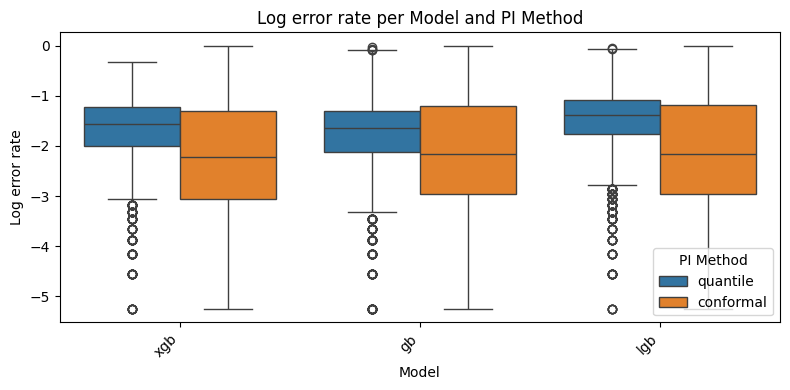

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Coverage plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='model', y='log_error_rate', hue='pi_method', data=df)
plt.title('Log error rate per Model and PI Method')
plt.xlabel('Model')
plt.ylabel('Log error rate')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PI Method')
plt.tight_layout()
plt.show()

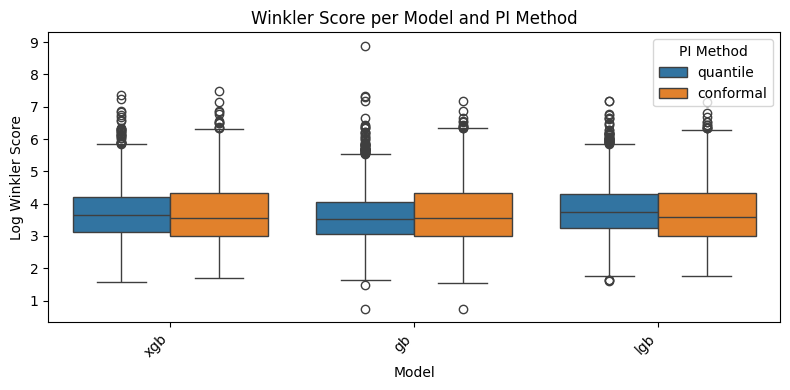

In [50]:
# Winkler plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='model', y='log_winkler', hue='pi_method', data=df)
plt.title('Log Winkler Score per Model and PI Method')
plt.xlabel('Model')
plt.ylabel('Log Winkler Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PI Method')
plt.tight_layout()
plt.show()

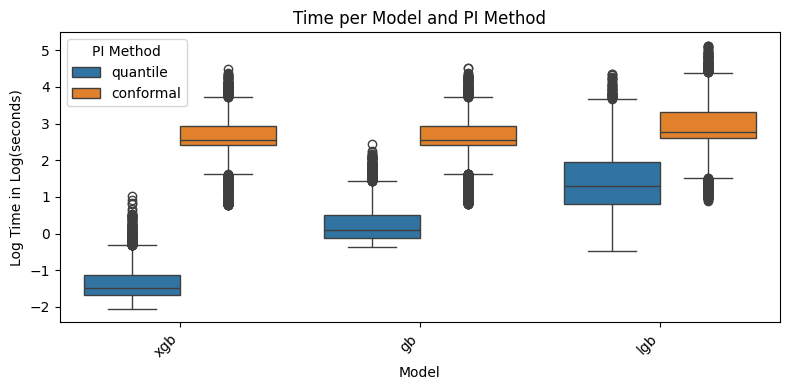

In [51]:
# Time plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='model', y='log_time', hue='pi_method', data=df)
plt.title('Time per Model and PI Method')
plt.xlabel('Model')
plt.ylabel('Log Time in Log(seconds)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PI Method')
plt.tight_layout()
plt.show()

# Session info

In [52]:
!pip freeze

annotated-types==0.7.0
appdirs==1.4.4
appnope==0.1.4
arrow==1.3.0
astor==0.8.1
asttokens==2.4.1
attrs==24.2.0
backoff==2.2.1
cachetools==5.5.0
certifi==2024.8.30
charset-normalizer==3.4.0
comm==0.2.2
contourpy==1.3.0
cycler==0.12.1
dacite==1.8.1
dateutils==0.6.12
debugpy==1.8.7
decorator==5.1.1
duckdb==1.1.2
executing==2.1.0
fonttools==4.54.1
greenlet==3.1.1
gw_dsl_parser==0.1.49.1
htmlmin==0.1.12
idna==3.10
ImageHash==4.3.1
importlib_resources==6.4.5
ipykernel==6.29.5
ipylab==1.0.0
ipython==8.28.0
ipywidgets==8.1.5
jedi==0.19.1
Jinja2==3.1.4
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
jupyterlab_widgets==3.0.13
kanaries_track==0.0.5
kiwisolver==1.4.7
lightgbm==4.5.0
llvmlite==0.43.0
MarkupSafe==3.0.2
matplotlib==3.9.2
matplotlib-inline==0.1.7
monotonic==1.6
multimethod==1.12
nest-asyncio==1.6.0
networkx==3.4.2
nnetsauce==0.25.10
numba==0.60.0
numpy==1.26.4
packaging==24.1
pandas==2.2.3
parso==0.8.4
patsy==0.5.6
pexpect==4.9.0
phik==0.12.4
pillow==11.0.0
platformdirs==4.3.6

In [56]:
import platform

# Get basic machine information
python_version = platform.python_version()

print("Python Version:", python_version)


Python Version: 3.11.10


In [55]:
import psutil

# CPU Information
cpu_count = psutil.cpu_count(logical=True)
cpu_freq = psutil.cpu_freq()
cpu_usage = psutil.cpu_percent(interval=1)

# Memory Information
virtual_memory = psutil.virtual_memory()
swap_memory = psutil.swap_memory()

# Disk Information
disk_usage = psutil.disk_usage('/')

print(f"CPU Count: {cpu_count}")
print(f"CPU Frequency: {cpu_freq.current} MHz")

CPU Count: 8
CPU Frequency: 1100 MHz
